In [1]:
import os
import string
import pandas as pd
import numpy as np
import gensim
import unicodedata
from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import pyLDAvis.gensim
import json
import html
import warnings
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
stemmer = PorterStemmer()
pyLDAvis.enable_notebook()
os.environ.update({'MALLET_HOME':'./Mallet'}) 
mallet_path = './Mallet/bin/mallet' 
current_dir = os.getcwd()
coherence_scores = []

In [3]:
def convert(o):
    if isinstance(o, np.int64): return int(o)  
    raise TypeError

In [4]:
# stop words set
STOP_WORDS_FILES = ['mallet_stop_words.txt', 'custom_stop_words.txt']
stop_words_set = set()
stop_words = set(stopwords.words('english'))
for word in stop_words:
    if('\'' in word):
        stop_words_set.add(word.strip().replace('\'', ''))
    stop_words_set.add(word)
for swfile in STOP_WORDS_FILES:
    try:
        with open(swfile, 'r') as f:
            words = f.readlines()
            for word in words:
                if('\'' in word):
                    stop_words_set.add(word.strip().replace('\'', ''))
                stop_words_set.add(word.strip())
    except:
        pass

In [5]:
def preprocess_text(text):
    # remove non ascii
    text = unicodedata.normalize('NFKD', text).encode(
        'ascii', 'ignore').decode('utf-8', 'ignore')
    text = text.lower()
    # unescaping
    text = html.unescape(text)
    text = re.sub(r'<code>(.|\n)*?</code>','', text) # removing <code>...</code>
    text = re.sub(r'<a.*?</a>', '', text)  # removing whole anchor tags
    text = re.sub(r'(<.*?>)', '', text)  # removing html markup
    text = re.sub(r'[^\w\s]', '', text)  # removing punctuation
    text = re.sub(r'[\d]', '', text)  # removing digits
    # remove stopwords
    tokenized = []
    for word in text.split():
        if word in stop_words_set:
            continue
        tokenized.append(word)
    for i in range(len(tokenized)):
        word = tokenized[i]
        word = WordNetLemmatizer().lemmatize(word, pos='v')
        tokenized[i] = stemmer.stem(word)
        # tokenized[i] = word
    return tokenized

In [6]:
df=pd.read_csv("so_body.csv")
df['preprocessed'] = ""
for i in range(len(df)):
    df['preprocessed'].iloc[i] = preprocess_text(df.raw.iloc[i])
df.to_csv('preprocesseedData.csv')
df.head()

,id,qa,raw,preprocessed
0,326366,q,Experiences with Zoho Creator? <p>I wish to cr...,"[experi, creator, onlin, system, track, thing,..."
1,359717,q,What's the best free resource to learn about M...,"[what, free, resourc, learn, ms, ii, ii, conju..."
2,544097,q,Create lightning in OpenGL ES 1.1 <p>I need to...,"[opengl, es, good, opengl, es, iphon, plan, sh..."
3,980932,q,"Python QuickBase API Help <p>Hey, I'm having ...","[python, api, hey, im, troubl, api, python, gu..."
4,1236439,q,How do generate screen elements dynamically in...,"[gener, screen, element, dynam, platform, plat..."


In [9]:
def create_dir(parent_dir, dir_name):
    temp = os.path.join(parent_dir,dir_name)
    try:  
        os.mkdir(temp)  
    except OSError as error:  
        # print(error)
        pass
    return temp

def make_link(id,type):
    '''
    id = postid
    type : 'q' for question
           'a' for answer
    '''
    url = f'https://stackoverflow.com/{type}/{id}'
    return f'=HYPERLINK("{url}", "{id}")'

100%|██████████| 26/26 [18:11<00:00, 41.98s/it]


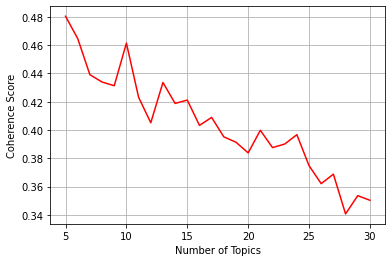

In [10]:
# finding out optimum topic number
data = df['preprocessed']
dictionary = gensim.corpora.Dictionary(data)
corpus = [dictionary.doc2bow(doc) for doc in data]
coherence_scores = []
for num_topics in tqdm(range(5,31)):
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha=50/num_topics)
    coherenceModel = CoherenceModel(model=ldamallet, texts=data, dictionary=dictionary, coherence='c_v')
    score = coherenceModel.get_coherence()
    coherence_scores.append([num_topics,score])
# save scores as csv
ch_df = pd.DataFrame(coherence_scores,columns=['Num Topic','Score'])
ch_df.to_csv('Coherence_Scores.csv')
# plot
plt.xlabel('Number of Topics') 
plt.ylabel('Coherence Score') 
x = []
y = []
for score in coherence_scores:
    x.append(score[0])
    y.append(score[1])
plt.plot(x,y,c='r')
plt.gca().set_aspect('auto')
plt.grid()
plt.savefig('scores.png', dpi=500)
plt.show()

In [11]:
res_dir = create_dir(current_dir, 'Topic Modeling Results')
data = df['preprocessed']
dictionary = gensim.corpora.Dictionary(data)
corpus = [dictionary.doc2bow(doc) for doc in data]
# create folder for topic number
NUM_TOPIS = [5,6,10,7,8,13,9,11,15]
for num_topics in NUM_TOPIS:
    topic_dir = create_dir(res_dir, f'{num_topics} Topics')
    if os.path.isfile(os.path.join(topic_dir, 'ldamallet.pkl')):
        ldamallet = pickle.load(
            open(os.path.join(topic_dir, 'ldamallet.pkl'), "rb"))
    else:
        ldamallet = gensim.models.wrappers.LdaMallet(
            mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha=50/num_topics)
        # save the model as pickle
        pickle.dump(ldamallet, open(os.path.join(
            topic_dir, 'ldamallet.pkl'), "wb"))
    topics = [[(word, word_prob) for word, word_prob in ldamallet.show_topic(
        n, topn=30)] for n in range(ldamallet.num_topics)]
    # term-topic matrix
    topics_df = pd.DataFrame([[f'{word} {round(word_prob,4)}' for word, word_prob in topic] for topic in topics], columns=[
        f'Term {i}' for i in range(1, 31)], index=[f'Topic {n}' for n in range(ldamallet.num_topics)]).T
    topics_df.to_csv(os.path.join(topic_dir, 'term x topic.csv'))
    # topic words
    topic_words_dir = create_dir(topic_dir, 'TopicWords')
    for n in range(num_topics):
        topic_words_df = pd.DataFrame(
            [[word_prob, word]for word, word_prob in topics[n]], columns=['Prob', 'Word'])
        topic_words_df.to_csv(os.path.join(topic_words_dir, f'{n}.csv'))
    # post to dominant topic
    corpus_topic_df = pd.DataFrame()
    corpus_topic_df['link'] = df.id
    corpus_topic_df['qa'] = df.qa
    for i in range(len(corpus_topic_df)):
        corpus_topic_df.link.iloc[i] = make_link(df.id.iloc[i],df.qa.iloc[i])
    topic_model_results = ldamallet[corpus]
    corpus_topics = [sorted(doc, key=lambda x: -x[1])[0]
                    for doc in topic_model_results]
    corpus_topic_df['Dominant Topic'] = [item[0] for item in corpus_topics]
    corpus_topic_df['Correlation'] = [item[1] for item in corpus_topics]
    corpus_topic_df.to_csv(os.path.join(topic_dir, 'postToTopic.csv'))
    topic_to_post_dir = create_dir(topic_dir, 'TopicToPost')
    for i in range(num_topics):
        temp = create_dir(topic_to_post_dir, str(i))
        temp_q_df = corpus_topic_df.loc[corpus_topic_df['Dominant Topic'] == i]
        temp_q_df = temp_q_df.loc[temp_q_df['qa'] == 'q']
        temp_a_df = corpus_topic_df.loc[corpus_topic_df['Dominant Topic'] == i]
        temp_a_df = temp_a_df.loc[temp_a_df['qa'] == 'a']
        temp_q_df.drop(columns=['Dominant Topic','qa']).to_csv(
            os.path.join(temp, 'Questions.csv'), index=False)
        temp_q_df.drop(columns=['Dominant Topic','qa']).to_excel(
            os.path.join(temp, 'Questions.xlsx'), index=False)
        temp_a_df.drop(columns=['Dominant Topic','qa']).to_csv(
            os.path.join(temp, 'Answers.csv'), index=False)
        temp_a_df.drop(columns=['Dominant Topic','qa']).to_excel(
            os.path.join(temp, 'Answers.xlsx'), index=False)
    # post count under any topic
    topic_post_cnt_df = corpus_topic_df.groupby('Dominant Topic').agg(
        Document_Count=('Dominant Topic', np.size),
        Percentage=('Dominant Topic', np.size)).reset_index()
    topic_post_cnt_df['Percentage'] = topic_post_cnt_df['Percentage'].apply(
        lambda x: round((x*100) / len(corpus), 2))
    topic_post_cnt_df.to_csv(os.path.join(topic_dir, 'postPerTopic.csv'))
    # pyLDAvis
    vis = pyLDAvis.gensim.prepare(
        gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet), corpus, dictionary)
    pyLDAvis.save_html(vis, os.path.join(topic_dir, f'pyLDAvis.html'))